# Task

### Pre-defined Code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Mounted at /content/drive


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


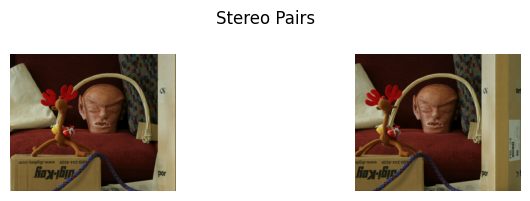

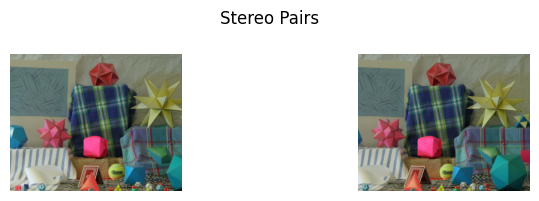

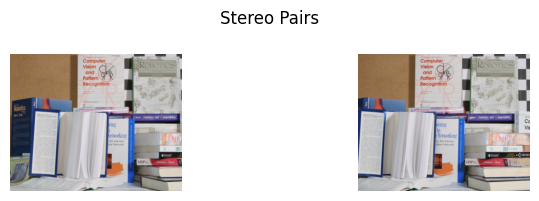

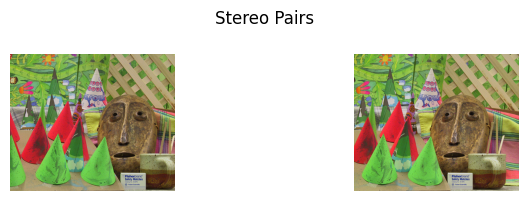

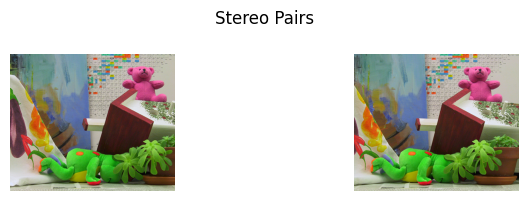

In [ ]:
# Loading all the images in the drive
pair_images = []

paths = natsorted(glob('/content/drive/My Drive/ES666CV/Images/E/*'))

for idx in tqdm(range(0, len(paths), 2)):
    pair_images.append(np.array([cv2.imread(paths[idx], 1), cv2.imread(paths[idx+1], 1)]))

for pairs in pair_images:
    show_image_grid(pairs, 1, 2, 'Stereo Pairs', figsize=8)

### Reconstruction Algorithm

1. [Reconstruction](https://www.cs.cmu.edu/~16385/s15/lectures/Lecture19.pdf) [Must Read]

2. [Stereo and Disparity](https://johnwlambert.github.io/stereo/)

3. [Stereo and 3D Vision](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect16.pdf)

4. [Stereo Reconstruction](https://cs.nyu.edu/~fergus/teaching/vision/9_10_Stereo.pdf)

5. [Epipolar Geometry and the Fundamental Matrix](https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf)

### Q1: Matching Points [2 Marks]

Find the matching points between image pair. You can use OpenCV SIFT feature matching. Plot the matching points over the image.

In [ ]:
def build_matching_point_pairs(image_a, image_b):
    matching_point_pair_lst = [[],[]] # [[image_a points], [image_b points]]
    sift = cv2.SIFT_create()   # Feature matching
    keypoints1, descriptors1 = sift.detectAndCompute(image_a, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image_b, None)
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    ratio_threshold = 0.6
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)
    for match in good_matches:
      pt_a = keypoints1[match.queryIdx].pt  # Keypoint coordinates in image_a
      pt_b = keypoints2[match.trainIdx].pt  # Keypoint coordinates in image_b
      matching_point_pair_lst[0].append(pt_a)
      matching_point_pair_lst[1].append(pt_b)



    return matching_point_pair_lst,keypoints1,keypoints2,good_matches

2


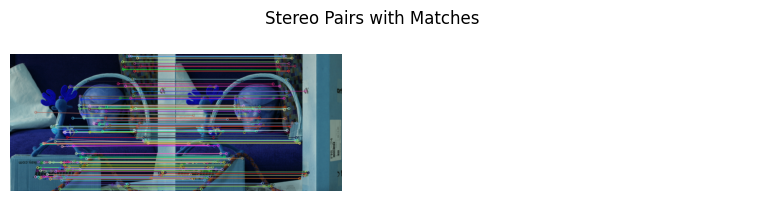

2


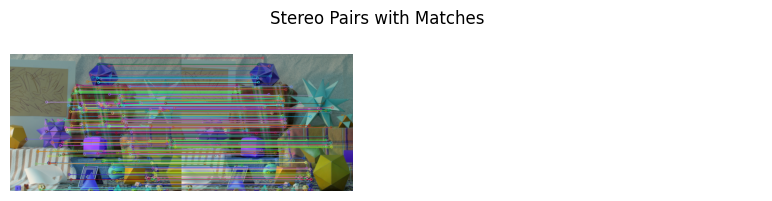

2


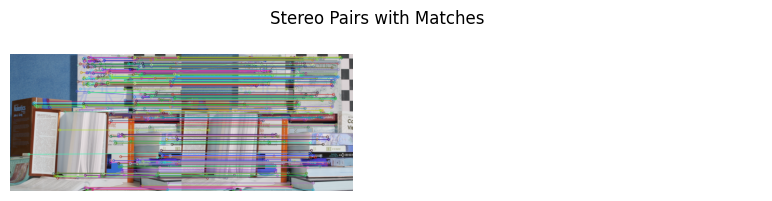

2


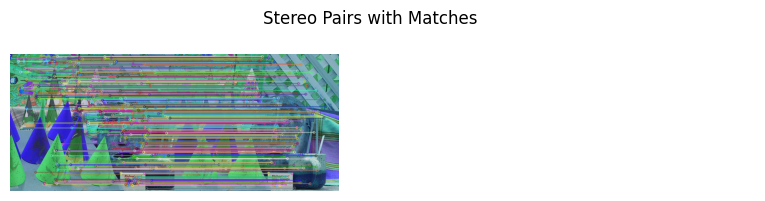

2


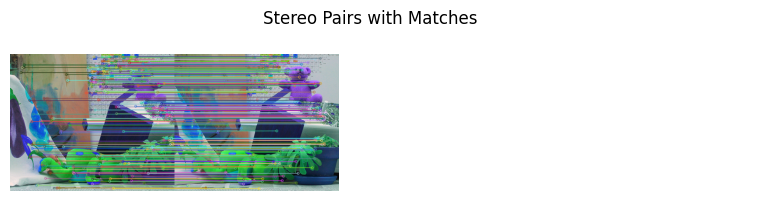

In [ ]:

global_matching_point_pair_lst = []
for pairs in pair_images:
    matching_point_pair,keypoints1,keypoints2,good_matches = build_matching_point_pairs(pairs[0], pairs[1])
    global_matching_point_pair_lst.append(matching_point_pair)
    img_a, img_b = pairs[0], pairs[1]
    matched_image = cv2.drawMatches(
        img_a, keypoints1, img_b, keypoints2, good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    print(len(matching_point_pair))
    matched_image = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)
    show_image_grid(matched_image, 1, 2, title='Stereo Pairs with Matches', figsize=8)




### Q2: Estimate Camera Matrix [3 Marks]

Estimate the camera matrix [R | t] using matched points, for this question also you are allow to use OpenCV estimate Essential matrix and Camera matrix function.

In [ ]:
def estimate_camera_matrix(matching_point_a, matching_point_b):

    points_a = np.array(matching_point_a)
    points_b = np.array(matching_point_b)


    if len(points_a) < 8 or len(points_b) < 8:
        raise ValueError("At least 8 point correspondences are required.")

    # Estimate the essential matrix
    E, mask = cv2.findEssentialMat(points_a, points_b, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    # Decompose the essential matrix to get R and t
    _, R, t, mask = cv2.recoverPose(E, points_a, points_b)

    # Create the camera matrix [R | t]
    camera_matrix = np.hstack((R, t))

    return camera_matrix

In [ ]:
global_camera_matrix_lst = []

for matching_point_pair in global_matching_point_pair_lst:
    global_camera_matrix_lst.append(estimate_camera_matrix(matching_point_pair[0], matching_point_pair[1]))
print(global_camera_matrix_lst)

[array([[ 9.99998116e-01,  1.94116672e-03,  3.72470399e-06,
        -9.99409072e-01],
       [-1.94116677e-03,  9.99998116e-01,  1.24582978e-05,
         3.43726778e-02],
       [-3.70051334e-06, -1.24655046e-05,  1.00000000e+00,
         1.61990848e-04]]), array([[ 9.99967628e-01, -8.04617772e-03, -3.90673739e-05,
        -9.98755327e-01],
       [ 8.04617757e-03,  9.99967629e-01, -3.93021596e-06,
        -4.98771020e-02],
       [ 3.90977325e-05,  3.61574571e-06,  9.99999999e-01,
        -2.66345666e-04]]), array([[ 9.99999987e-01,  1.58964014e-04,  1.48456539e-06,
        -9.99999686e-01],
       [-1.58964011e-04,  9.99999987e-01, -1.67522450e-06,
         7.91843079e-04],
       [-1.48483167e-06,  1.67498849e-06,  1.00000000e+00,
        -1.72145049e-05]]), array([[ 9.99999841e-01, -5.63628892e-04,  9.56582070e-07,
        -9.99913947e-01],
       [ 5.63628894e-04,  9.99999841e-01, -1.92085394e-06,
        -1.31185567e-02],
       [-9.55499270e-07,  1.92139279e-06,  1.00000000e+00,

### Q3: Stereo Rectification [2.5 Marks]

You have to perform stereo rectification based on the estimated camera matrix. This will help is algining the image pair which in turn help estimate disparity map easily.

Note: Implement it from scratch no use of OpenCV function is allowed for this part of the algorithm other than warping function if needed.

In [ ]:
import numpy as np
import cv2

def perform_stereo_rectification(image_a, image_b, matching_point_a, matching_point_b, camera_matrix):
    # Extract the intrinsic matrix (first 3x3 part of the camera matrix)
    fx = fy = 1
    intrinsic_matrix = np.array([[fx, 0, 0],
                 [0, fy, 0],
                [0, 0, 1]], dtype=np.float64)

    dist_coeffs = np.zeros((4, 1), dtype=np.float64)

    # Image size (width, height)
    image_size = image_a.shape[:2][::-1]
    R = np.eye(3, dtype=np.float64)  # Identity rotation matrix
    T = np.array([1, 0, 0], dtype=np.float64)  # Example translation vector

    # Compute rectification transforms
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
        cameraMatrix1=intrinsic_matrix, distCoeffs1=dist_coeffs,
        cameraMatrix2=intrinsic_matrix, distCoeffs2=dist_coeffs,
        imageSize=image_size, R=R, T=T
    )

    # Generate undistort rectify maps
    map1_a, map2_a = cv2.initUndistortRectifyMap(
        cameraMatrix=intrinsic_matrix, distCoeffs=dist_coeffs, R=R1, newCameraMatrix=P1,
        size=image_size, m1type=cv2.CV_32FC1
    )
    map1_b, map2_b = cv2.initUndistortRectifyMap(
        cameraMatrix=intrinsic_matrix, distCoeffs=dist_coeffs, R=R2, newCameraMatrix=P2,
        size=image_size, m1type=cv2.CV_32FC1
    )

    # Apply rectification
    image_a_rectified = cv2.remap(image_a, map1_a, map2_a, interpolation=cv2.INTER_LINEAR)
    image_b_rectified = cv2.remap(image_b, map1_b, map2_b, interpolation=cv2.INTER_LINEAR)

    return [image_a_rectified, image_b_rectified]


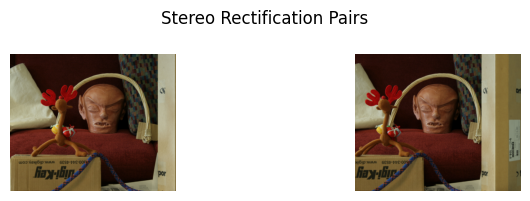

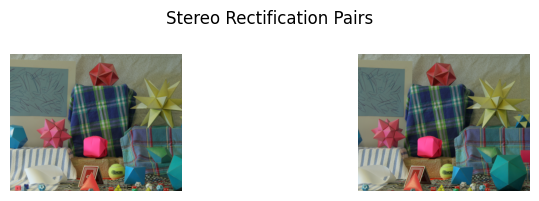

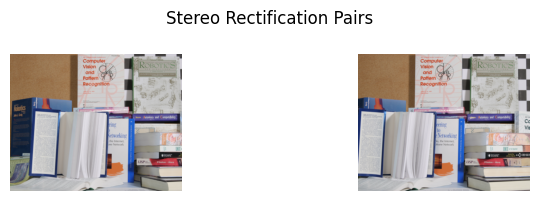

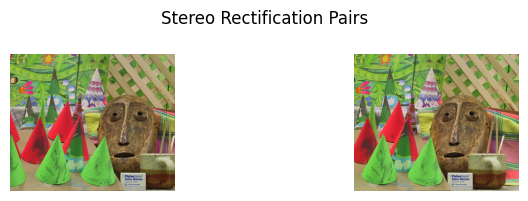

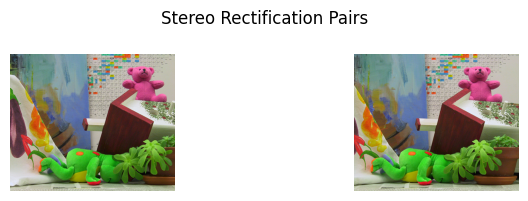

In [ ]:
N = len(pair_images)  # Total stereo image pairs
rectified_pairs = []

for pair_idx in range(N):
    algined_pairs = perform_stereo_rectification(pair_images[pair_idx][0], pair_images[pair_idx][1],\
                                 global_matching_point_pair_lst[pair_idx][0], global_matching_point_pair_lst[pair_idx][1],\
                                 global_camera_matrix_lst[pair_idx])

    rectified_pairs.append(np.array(algined_pairs))
    show_image_grid(rectified_pairs[-1], 1, 2, 'Stereo Rectification Pairs', figsize=8)

### Q4: Disparity Maps [2.5 Marks]

With the help of stereo rectification images, now have to obtain the disparity maps for each pair. No opencv functions are allowed for this algorithm. For convolution you can use scipy or opencv convolution.

In [ ]:
import numpy as np
from scipy.signal import convolve2d

def disparity_map(image_a, image_b, window_size=5, max_disparity=64):
    if len(image_a.shape) == 3:
        image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
    if len(image_b.shape) == 3:
        image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)
    height, width = image_a.shape
    disp_map = np.zeros_like(image_a)

    window = np.ones((window_size, window_size))
    for y in range(window_size // 2, height - window_size // 2):
        for x in range(window_size // 2, width - window_size // 2):
            best_match_score = float('inf')
            best_disp = 0

            # Try different disparities
            for disp in range(min(x, max_disparity)):
                # Define the region of interest in both images
                window_a = image_a[y - window_size // 2 : y + window_size // 2 + 1,
                                   x - window_size // 2 : x + window_size // 2 + 1]
                if x - disp - window_size // 2 >= 0:  # check bounds
                    window_b = image_b[y - window_size // 2 : y + window_size // 2 + 1,
                                       x - disp - window_size // 2 : x - disp + window_size // 2 + 1]
                else:
                    continue
                ssd = np.sum((window_a - window_b) ** 2)

                if ssd < best_match_score:
                    best_match_score = ssd
                    best_disp = disp
            disp_map[y, x] = best_disp

    return disp_map


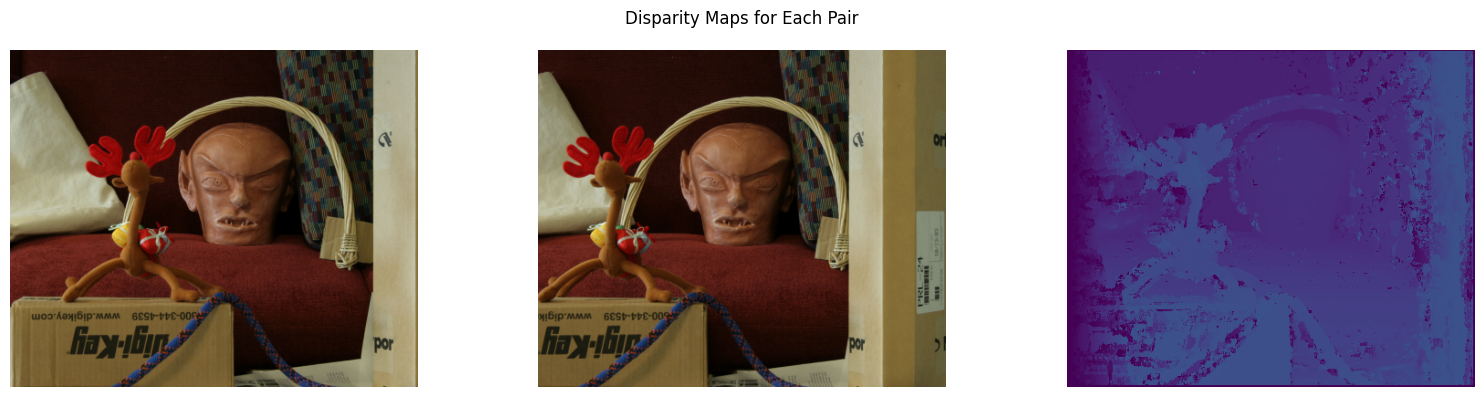

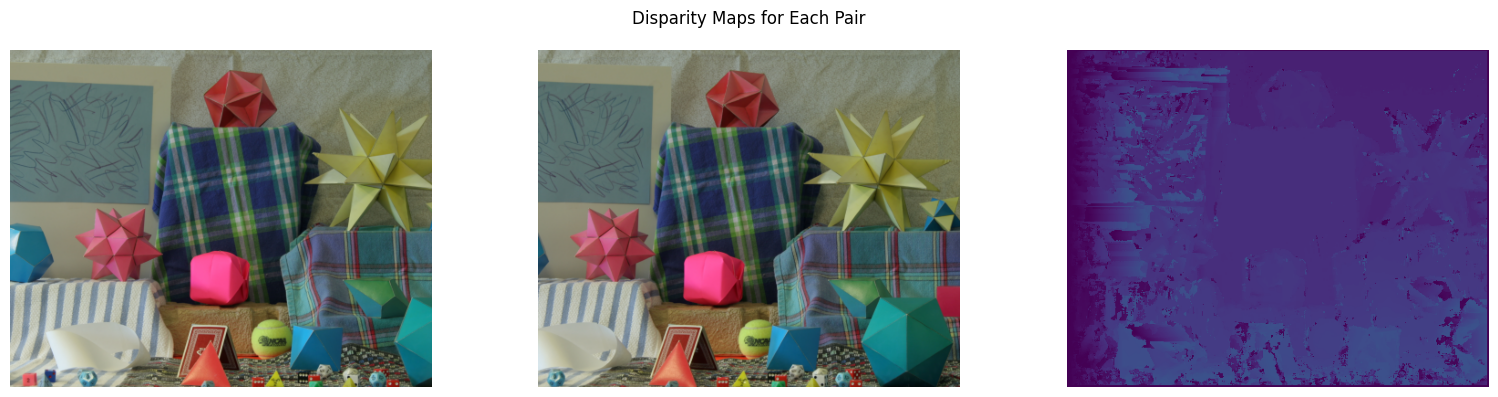

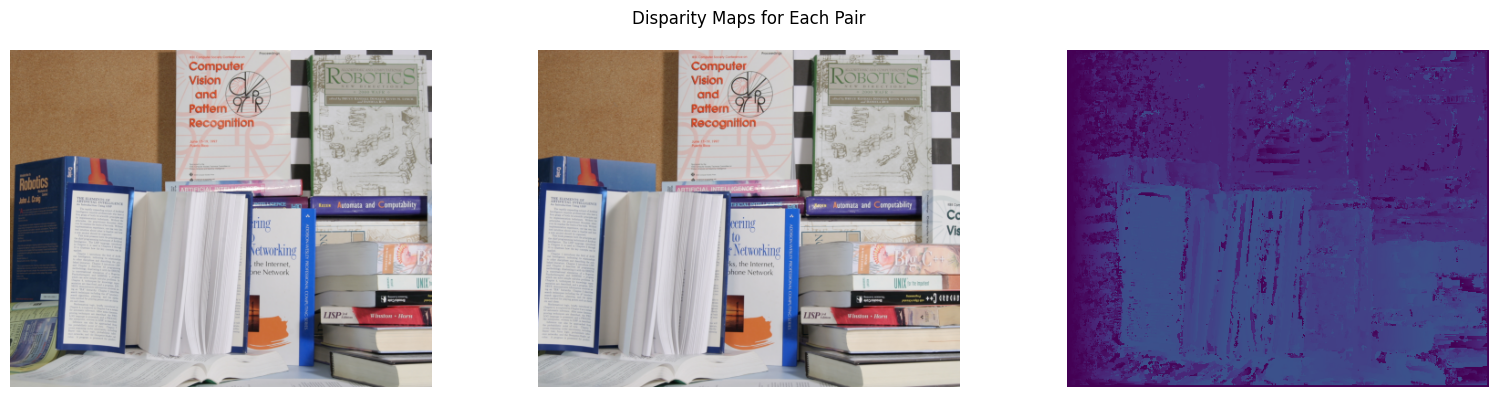

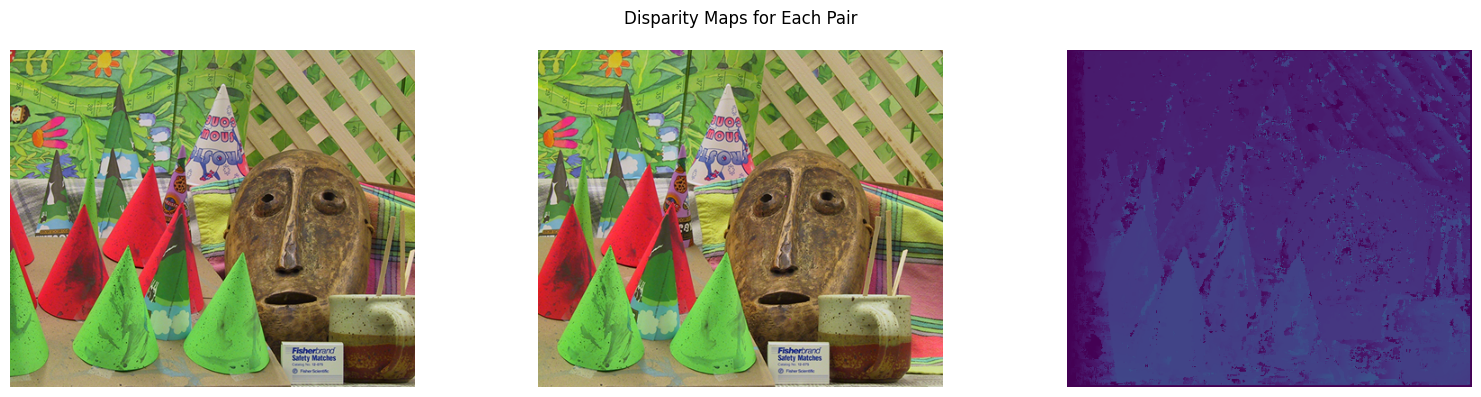

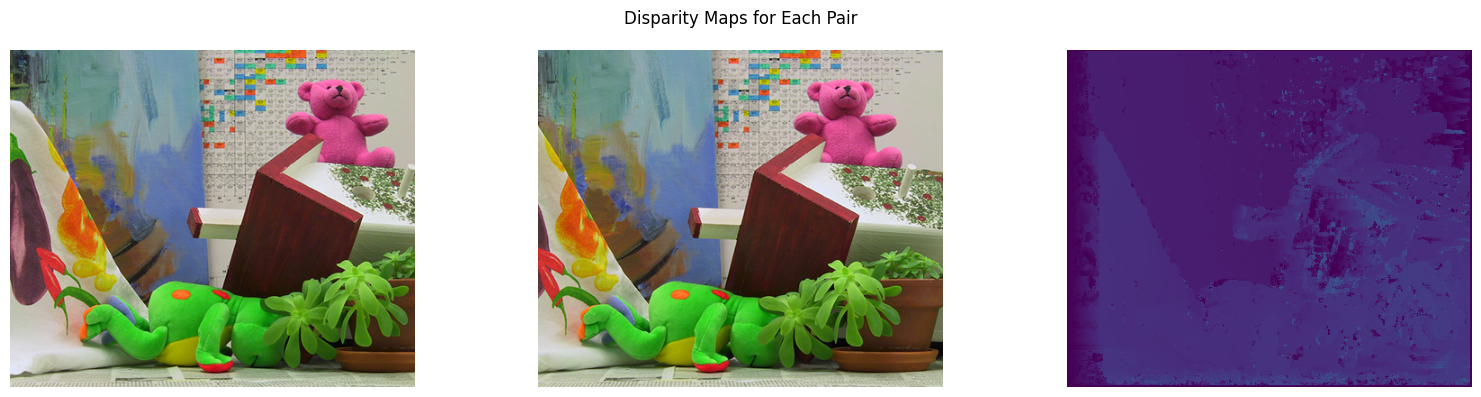

In [ ]:
for pairs in rectified_pairs:
    disp_map = disparity_map(pairs[0], pairs[1])
    disp_map = cv2.applyColorMap(disp_map, cv2.COLORMAP_VIRIDIS) # disp_map is single channel image
    show_image_grid(np.array([pairs[0], pairs[1], disp_map]), 1, 3, 'Disparity Maps for Each Pair', figsize=16)